In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Google Drive Paths
content_dir = "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/AdaIN/content"
style_dir = "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/style"

In [ ]:
# Imports

import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms
from torchvision.utils import save_image
from pathlib import Path

In [ ]:
# Conditional Instance Normalization Layer

class ConditionalInstanceNorm2d(nn.Module):
    def __init__(self, num_features, num_styles):
        super().__init__()
        self.num_features = num_features
        self.num_styles = num_styles

        self.gamma = nn.Embedding(num_styles, num_features)
        self.beta = nn.Embedding(num_styles, num_features)

        nn.init.ones_(self.gamma.weight)
        nn.init.zeros_(self.beta.weight)

        self.instance_norm = nn.InstanceNorm2d(num_features, affine=False)

    def forward(self, x, style_id):
        x_norm = self.instance_norm(x)

        # Style Interpolation Support
        if isinstance(style_id, tuple):
            sid1, sid2, alpha = style_id
            gamma1 = self.gamma(sid1).view(-1, self.num_features, 1, 1)
            beta1 = self.beta(sid1).view(-1, self.num_features, 1, 1)
            gamma2 = self.gamma(sid2).view(-1, self.num_features, 1, 1)
            beta2 = self.beta(sid2).view(-1, self.num_features, 1, 1)

            gamma = (1 - alpha) * gamma1 + alpha * gamma2
            beta = (1 - alpha) * beta1 + alpha * beta2

        # Single Style
        else:
            gamma = self.gamma(style_id).view(-1, self.num_features, 1, 1)
            beta = self.beta(style_id).view(-1, self.num_features, 1, 1)

        return gamma * x_norm + beta

In [ ]:
# Residual Block

class ResidualBlock(nn.Module):
    def __init__(self, channels, num_styles):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.in1 = ConditionalInstanceNorm2d(channels, num_styles)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.in2 = ConditionalInstanceNorm2d(channels, num_styles)

    def forward(self, x, style_id):
        residual = x
        x = F.relu(self.in1(self.conv1(x), style_id))
        x = self.in2(self.conv2(x), style_id)
        return x + residual

In [ ]:
# Style Transfer Network

class StyleTransferNet(nn.Module):
    def __init__(self, num_styles):
        super().__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 32, kernel_size=9, stride=1, padding=4, padding_mode='reflect')
        self.in1 = ConditionalInstanceNorm2d(32, num_styles)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, padding_mode='reflect')
        self.in2 = ConditionalInstanceNorm2d(64, num_styles)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, padding_mode='reflect')
        self.in3 = ConditionalInstanceNorm2d(128, num_styles)

        # Residual blocks
        self.res_blocks = nn.ModuleList([ResidualBlock(128, num_styles) for _ in range(5)])

        # Decoder (Upsampling + Convolution)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.deconv1 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.in4 = ConditionalInstanceNorm2d(64, num_styles)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.deconv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.in5 = ConditionalInstanceNorm2d(32, num_styles)

        # Output layer
        self.conv_out = nn.Conv2d(32, 3, kernel_size=9, stride=1, padding=4, padding_mode='reflect')

    def forward(self, x, style_id):
        x = F.relu(self.in1(self.conv1(x), style_id))
        x = F.relu(self.in2(self.conv2(x), style_id))
        x = F.relu(self.in3(self.conv3(x), style_id))

        for res_block in self.res_blocks:
            x = res_block(x, style_id)

        x = self.upsample1(x)
        x = F.relu(self.in4(self.deconv1(x), style_id))

        x = self.upsample2(x)
        x = F.relu(self.in5(self.deconv2(x), style_id))

        x = torch.sigmoid(self.conv_out(x))  # Final sigmoid activation
        return x

In [ ]:
# VGG Perceptual Loss

class VGGPerceptualLoss(nn.Module):

    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features
        self.slice1 = nn.Sequential(*list(vgg.children())[:4])    # relu1_2
        self.slice2 = nn.Sequential(*list(vgg.children())[4:9])   # relu2_2
        self.slice3 = nn.Sequential(*list(vgg.children())[9:16])  # relu3_3
        self.slice4 = nn.Sequential(*list(vgg.children())[16:23]) # relu4_3
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        return [h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3]

    def gram_matrix(self, x):
        B, C, H, W = x.size()
        features = x.view(B, C, H * W)
        G = torch.bmm(features, features.transpose(1, 2))
        return G / (C * H * W)

In [ ]:
# Content Image Dataset

class ContentImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                      if f.endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        try:
            img = Image.open(self.files[idx]).convert("RGB")
            if self.transform:
                img = self.transform(img)
            return img
        except Exception as e:
            print(f"Skipping image: {self.files[idx]} ({e})")
            return self.__getitem__((idx + 1) % len(self.files))

In [ ]:
# Style Images Loader

def load_style_images(style_folder, transform, device):
    style_imgs = []
    style_filenames = sorted([
        os.path.join(style_folder, f) for f in os.listdir(style_folder)
        if f.endswith(('.jpg', '.png'))
    ])
    for path in style_filenames:
        try:
            img = Image.open(path).convert('RGB')
            tensor = transform(img).unsqueeze(0).to(device)
            style_imgs.append(tensor)
        except Exception as e:
            print(f"Error loading {path}: {e}")
    return style_imgs

In [ ]:
# Sample Image Display During Training

def display_sample_images(pil_img, step):
    os.makedirs("outputs", exist_ok=True)
    output_path = f"outputs/sample_step_{step}.jpg"
    pil_img.save(output_path)
    display(pil_img)

In [ ]:
def normalise_batch(batch):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(batch.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(batch.device)
    return (batch - mean) / std

In [ ]:
def init_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight, mean=0.0, std=0.01)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

In [ ]:
def deprocess(tensor):
    tensor = tensor.clone().detach().cpu()
    tensor = tensor.squeeze(0)  # [1, 3, H, W] → [3, H, W]
    tensor = torch.clamp(tensor, 0, 1)  # ensure valid pixel range
    return transforms.ToPILImage()(tensor)

In [ ]:
# Training Loop
def train_style_transfer(model, content_loader, style_imgs, style_ids,
                         device, num_iterations=40000, lr=1e-3,
                         content_weight=1e4, style_weight=1e9,
                         checkpoint_path="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/checkpoints/MSPM_checkpoint.pth"):

    # Perceptual loss (VGG)
    vgg_loss = VGGPerceptualLoss().to(device)
    vgg_loss.eval()

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

    # Normalize style images once
    normalized_styles = [normalise_batch(s.clone()) for s in style_imgs]

    # Checkpoint Resume
    update_count = 0
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        update_count = checkpoint['update_count']
        print(f"Resuming training from iteration {update_count}/{num_iterations}")
    else:
        print("Starting training from scratch")

    # Training mode
    model.train()
    style_num = len(style_ids)

    while update_count < num_iterations:
        for content in content_loader:
            if update_count >= num_iterations:
                break

            content = content.to(device)
            B = content.size(0)

            # Cycle style index to guarantee even distribution
            current_style_id = style_ids[update_count % style_num]
            sid = torch.tensor([current_style_id] * B).to(device)

            # Forward pass
            stylized = model(content, sid)

            # Normalize for VGG
            content_norm = normalise_batch(content.clone())
            stylized_norm = normalise_batch(stylized.clone())
            style_norm = normalized_styles[current_style_id]

            # Compute content features
            content_feats = vgg_loss(content_norm)
            stylized_feats = vgg_loss(stylized_norm)

            # Content loss
            content_loss = F.mse_loss(stylized_feats[1], content_feats[1])

            # Style loss
            style_loss = 0
            style_feat = vgg_loss(style_norm)
            for j in range(B):
                for f1, f2 in zip(stylized_feats, style_feat):
                    G_styled = vgg_loss.gram_matrix(f1[j].unsqueeze(0))  # [1, C, C]
                    G_target = vgg_loss.gram_matrix(f2)                  # [1, C, C]
                    style_loss += F.mse_loss(G_styled, G_target)
            style_loss /= B

            # Total loss
            loss = content_weight * content_loss + style_weight * style_loss

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Logging
            if update_count % 100 == 0:
                print(f"Step {update_count}/{num_iterations} | Content Loss: {content_loss.item():.4f} | Style Loss: {style_loss.item():.4f}")
                with torch.no_grad():
                    sample = stylized[0:1].clone().detach()  # keep batch dim
                    sample = deprocess(sample)  # returns PIL image
                    display_sample_images(sample, update_count)

            # Save checkpoint
            if update_count % 500 == 0:
                os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'update_count': update_count
                }, checkpoint_path)

            update_count += 1

In [ ]:
def run_training_pipeline():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Collect style paths from Drive folder
    style_paths = [
        os.path.join(style_dir, f)
        for f in os.listdir(style_dir)
        if f.lower().endswith(('.jpg', '.png'))
    ]

    # Hyperparameters
    num_styles = len(style_paths)
    learning_rate = 1e-3

    # Transforms
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor()
    ])

    # Dataset and Dataloader
    content_dataset = ContentImageDataset(content_dir, transform)
    content_loader = torch.utils.data.DataLoader(content_dataset, batch_size=16, num_workers = 2, shuffle=True)

    # Load Style Images
    style_folder = style_dir
    style_imgs = load_style_images(style_folder, transform, device)
    style_ids = list(range(num_styles))  # simple integer IDs

    # Initialize Model
    model = StyleTransferNet(num_styles=num_styles).to(device)
    checkpoint_path = "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/checkpoints/MSPM_checkpoint.pth"

    if not os.path.exists(checkpoint_path):
        init_weights(model)  # Only initialize if starting fresh

    # Train
    train_style_transfer(model, content_loader, style_imgs, style_ids,
                         device=device, lr=learning_rate,
                         checkpoint_path=checkpoint_path)

    # Save the model
    torch.save(model.state_dict(), "/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/MSPM_model.pth")
    print("Model Saved")

    return model, num_styles, device

In [ ]:
model, num_styles, device = run_training_pipeline()

In [ ]:
def stylize_image(model,
                  content_image_path,
                  style_id,
                  style_dir="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/style",
                  output_dir="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/outputs",
                  device='cuda'):

    # Preprocess transforms
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor()
    ])
    to_pil = transforms.ToPILImage()

    # Load and preprocess content image
    content_img = Image.open(content_image_path).convert('RGB')
    content_tensor = transform(content_img).unsqueeze(0).to(device)  # [1, 3, H, W]

    # Get style image path by index
    style_files = sorted([
        os.path.join(style_dir, f)
        for f in os.listdir(style_dir)
        if f.lower().endswith(('.jpg', '.png'))
    ])
    style_image_path = style_files[style_id]
    style_img = Image.open(style_image_path).convert("RGB")
    style_display = style_img.resize((256, 256))
    style_tensor = transform(style_img).unsqueeze(0).to(device)

    # Stylize
    model.eval()
    with torch.no_grad():
        sid_tensor = torch.tensor([style_id], device=device)
        output_tensor = model(content_tensor, sid_tensor)

    # Convert to PIL
    output_tensor = output_tensor.clamp(0, 1)
    stylized_img = to_pil(output_tensor.squeeze(0))
    content_display = content_img.resize((256, 256))

    # Save output
    content_name = Path(content_image_path).stem
    output_filename = f"{content_name}_stylized_style{style_id}.jpg"
    os.makedirs(output_dir, exist_ok=True)
    stylized_img.save(os.path.join(output_dir, output_filename))

    # Display side-by-side
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(content_display)
    axs[0].set_title("Content")
    axs[0].axis("off")

    axs[1].imshow(style_display)
    axs[1].set_title("Style")
    axs[1].axis("off")

    axs[2].imshow(stylized_img)
    axs[2].set_title("Stylized")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
def stylize_image_interpolated(model,
                                content_image_path,
                                style_id1,
                                style_id2,
                                alpha,
                                style_dir="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/style",
                                output_dir="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/interpolated_outputs",
                                device='cuda'):

    # Preprocess transforms
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor()
    ])
    to_pil = transforms.ToPILImage()

    # Load and preprocess content image
    content_img = Image.open(content_image_path).convert('RGB')
    content_tensor = transform(content_img).unsqueeze(0).to(device)

    # Load and preprocess both style images
    style_files = sorted([
        os.path.join(style_dir, f)
        for f in os.listdir(style_dir)
        if f.lower().endswith(('.jpg', '.png'))
    ])
    style_img1 = Image.open(style_files[style_id1]).convert("RGB")
    style_img2 = Image.open(style_files[style_id2]).convert("RGB")

    style_display1 = style_img1.resize((256, 256))
    style_display2 = style_img2.resize((256, 256))

    # Stylize with interpolated style
    model.eval()
    with torch.no_grad():
        B = 1
        sid1_tensor = torch.tensor([style_id1] * B, device=device)
        sid2_tensor = torch.tensor([style_id2] * B, device=device)
        output_tensor = model(content_tensor, (sid1_tensor, sid2_tensor, alpha))

    # Convert to PIL
    output_tensor = output_tensor.clamp(0, 1)
    stylized_img = to_pil(output_tensor.squeeze(0))
    content_display = content_img.resize((256, 256))

    # Save output
    content_name = Path(content_image_path).stem
    output_filename = f"{content_name}_interpolated_s{style_id1}_s{style_id2}_a{alpha:.2f}.jpg"
    os.makedirs(output_dir, exist_ok=True)
    stylized_img.save(os.path.join(output_dir, output_filename))

    # Display side-by-side (Content, Style 1, Style 2, Stylized)
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(content_display)
    axs[0].set_title("Content")
    axs[0].axis("off")

    axs[1].imshow(style_display1)
    axs[1].set_title(f"Style {style_id1}")
    axs[1].axis("off")

    axs[2].imshow(style_display2)
    axs[2].set_title(f"Style {style_id2}")
    axs[2].axis("off")

    axs[3].imshow(stylized_img)
    axs[3].set_title(f"Interpolated α={alpha:.2f}")
    axs[3].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# Load the model
num_styles = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate the model architecture
model = StyleTransferNet(num_styles).to(device)

# Load the trained weights
model.load_state_dict(torch.load("/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/mspm_model_hyp_c10000.0_s1000000000.0_adam.pth", map_location=device))
model.eval()  # Set to evaluation mode

StyleTransferNet(
  (conv1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), padding_mode=reflect)
  (in1): ConditionalInstanceNorm2d(
    (gamma): Embedding(5, 32)
    (beta): Embedding(5, 32)
    (instance_norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
  (in2): ConditionalInstanceNorm2d(
    (gamma): Embedding(5, 64)
    (beta): Embedding(5, 64)
    (instance_norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
  (in3): ConditionalInstanceNorm2d(
    (gamma): Embedding(5, 128)
    (beta): Embedding(5, 128)
    (instance_norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (res_blocks): ModuleList(
    (0-4): 5 x ResidualBlock(
      (co

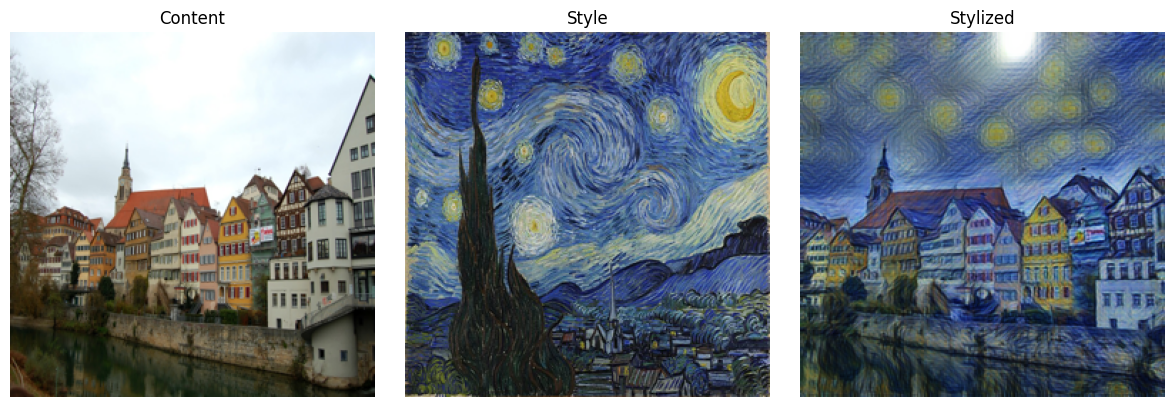

In [ ]:
stylize_image(
    model=model,
    content_image_path="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/houses_content.jpg",
    style_id=0,
    output_dir="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/outputs",
    device='cuda'
)

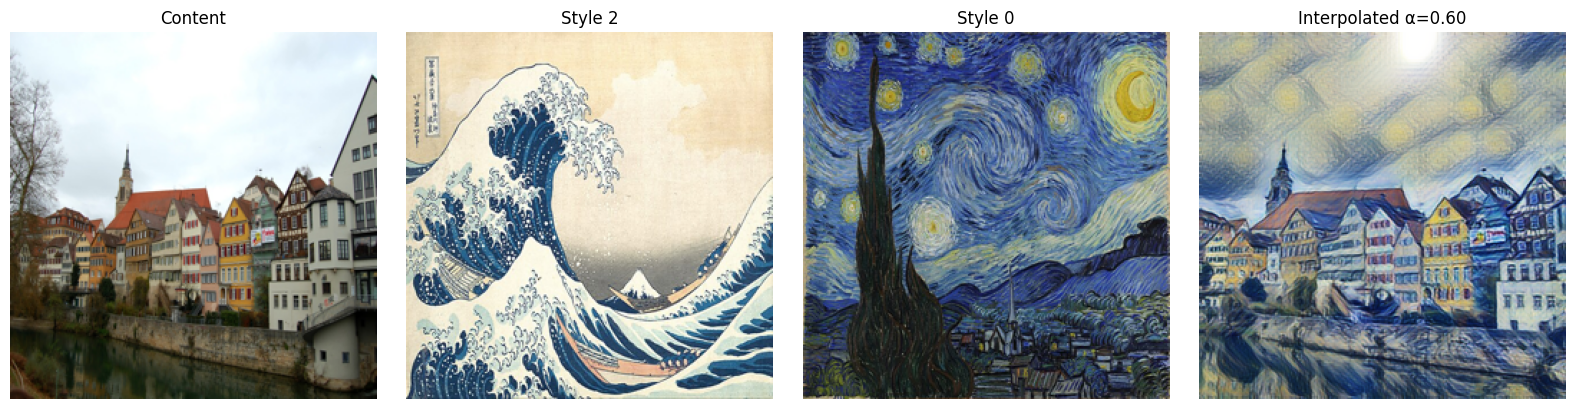

In [ ]:
stylize_image_interpolated(
    model=model,
    content_image_path="/content/drive/MyDrive/University of London/Year 3/FINAL PROJECT/Final Project Code/MSPM/houses_content.jpg",
    style_id1=2,
    style_id2=0,
    alpha=0.6,
    device='cuda'
)